In [35]:
# !wget https://data.vision.ee.ethz.ch/csergi/share/davis/DAVIS-2019-Unsupervised-test-dev-480p.zip

--2022-05-24 18:00:49--  https://data.vision.ee.ethz.ch/csergi/share/davis/DAVIS-2019-Unsupervised-test-dev-480p.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289138373 (276M) [application/zip]
Saving to: ‘DAVIS-2019-Unsupervised-test-dev-480p.zip’

DAVIS-2019-Unsuperv 100%[===================>] 275,74M  1,78MB/s    in 2m 54s  

2022-05-24 18:03:44 (1,59 MB/s) - ‘DAVIS-2019-Unsupervised-test-dev-480p.zip’ saved [289138373/289138373]



In [36]:
# !mkdir videos_test
# !unzip -d ./videos_test ./DAVIS-2019-Unsupervised-test-dev-480p.zip

Archive:  ./DAVIS-2019-Unsupervised-test-dev-480p.zip
   creating: ./videos_test/DAVIS/
  inflating: ./videos_test/DAVIS/README.md  
   creating: ./videos_test/DAVIS/ImageSets/
   creating: ./videos_test/DAVIS/ImageSets/2019/
  inflating: ./videos_test/DAVIS/ImageSets/2019/test-dev.txt  
  inflating: ./videos_test/DAVIS/SOURCES.md  
   creating: ./videos_test/DAVIS/JPEGImages/
   creating: ./videos_test/DAVIS/JPEGImages/480p/
   creating: ./videos_test/DAVIS/JPEGImages/480p/snowboard-race/
  inflating: ./videos_test/DAVIS/JPEGImages/480p/snowboard-race/00044.jpg  
  inflating: ./videos_test/DAVIS/JPEGImages/480p/snowboard-race/00061.jpg  
  inflating: ./videos_test/DAVIS/JPEGImages/480p/snowboard-race/00014.jpg  
  inflating: ./videos_test/DAVIS/JPEGImages/480p/snowboard-race/00069.jpg  
  inflating: ./videos_test/DAVIS/JPEGImages/480p/snowboard-race/00037.jpg  
  inflating: ./videos_test/DAVIS/JPEGImages/480p/snowboard-race/00015.jpg  
  inflating: ./videos_test/DAVIS/JPEGImages/480p/

In [3]:
# !pip install pytorch-lightning
# !pip install wandb

In [11]:
# !pip install albumentations

     |████████████████████████████████| 102 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 47.8 MB 725 kB/s eta 0:00:01    |████▍                           | 6.5 MB 5.6 MB/s eta 0:00:08


In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers import CSVLogger
import model_color
import matplotlib.pyplot as plt
import utils
import remasternet
import numpy as np
import torch
from PIL import Image

In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
import albumentations as A
import torch.nn.functional as F
import random
import torchvision.transforms as transforms

transform_reference_train = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.5, 0.8)),
    transforms.RandomHorizontalFlip()
])

transform_reference_test = transforms.Compose([
    transforms.Resize(128)
])

def transform_train(left_images, right_images):
    crop_size = 128
    width, height = transforms.functional.get_image_size(left_images)
    random_top = np.random.randint(0, height - crop_size + 1)
    random_left = np.random.randint(0, width - crop_size + 1)

    left_images = transforms.functional.crop(left_images, random_top, random_left, crop_size, crop_size)
    right_images = transforms.functional.crop(right_images, random_top, random_left, crop_size, crop_size)
    
    p = random.random()
    if p < 0.5:
        left_images = transforms.functional.hflip(left_images)
        right_images = transforms.functional.hflip(right_images)
    
    random_rotate = np.random.uniform(-5, 5)
    left_images = transforms.functional.rotate(left_images, random_rotate)
    right_images = transforms.functional.rotate(right_images, random_rotate)
    
#     random_brightness = np.random.uniform(0.8, 1.2)
#     p = random.random()
#     if p < 0.2:
#         left_images = transforms.functional.adjust_brightness(left_images.permute(1,0,2,3), random_brightness).permute(1,0,2,3)
#         right_images = transforms.functional.adjust_brightness(right_images.permute(1,0,2,3), random_brightness).permute(1,0,2,3)
        
    return left_images, right_images

def transform_test(left_images, right_images):
    resize_size = 128

    left_images = transforms.functional.resize(left_images, resize_size)
    right_images = transforms.functional.resize(right_images, resize_size)
        
    return left_images, right_images

In [14]:
dataset_train = model_color.VideoDataset('./videos/DAVIS/JPEGImages/480p', transform=transform_train, reference_transform=transform_reference_train,
                                                                           img_size=224, frame_stack=5, reference_size=4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:03<00:00,  1.42it/s]


In [19]:
dataset_test = model_color.VideoDataset('./videos_test/DAVIS/JPEGImages/480p', transform=transform_test, reference_transform=transform_reference_test,
                                                                               img_size=224, max_videos=10, frame_stack=5, reference_size=4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]


In [20]:
frames, targets, reference = dataset_test[0]
print(reference.shape)

torch.Size([3, 4, 128, 128])


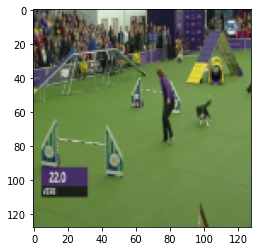

In [21]:
# plt.imshow(np.uint8(utils.convertLAB2RGB(reference[:, 0, :, :].numpy().transpose((1, 2, 0)) * 255)))
plt.imshow(utils.convertLAB2RGB(reference[:, 0, :, :].numpy().transpose((1, 2, 0))))
plt.show()

In [22]:
!wandb login

wandb: Currently logged in as: levenson (use `wandb login --relogin` to force relogin)


In [28]:
import wandb

def train(model, experiment_name, use_gpu):
    assignment_dir = './colorization'

    logger = WandbLogger(project='colorization_baseline', save_dir=f'{assignment_dir}/logs', name=experiment_name)
    logger.watch(model, log_freq=100)

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='lpips',
        dirpath=f'{assignment_dir}/logs/{experiment_name}',
        filename='{epoch:02d}',
        every_n_epochs=10,
        mode='max')

    trainer = pl.Trainer(
        max_epochs=200,
        gpus=1 if use_gpu else None, 
        benchmark=True, 
        logger=logger,
        log_every_n_steps=10,
        check_val_every_n_epoch=10,
        callbacks=[checkpoint_callback],
        #fast_dev_run=True
        ) 
    
    trainer.fit(model)
    wandb.finish()

In [29]:
import model_color

model = model_color.ColorModel(dataset_train, dataset_test, batch_size=16, lr=1e-4, wd=1e-6)
train(model, 'deepremaster', use_gpu=True)

wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-05-25 15:09:11.721297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hdilab02/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-05-25 15:09:11.721327: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | net        | NetworkC  | 10.7 M
1 | train_loss | TrainLoss | 0     
2 | val_loss   | ValLoss   | 12.9 M
-----------------------------------------
10.7 M    Trainable params
12.9 M    Non-trainable params
23.7 M    Total params
94.757    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/hdilab02/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:487: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
l1_rgb,▇▆█▅▄▆▅▅▄▄▅▃▄▃▁
lpips,▆█▇▅▅▇▇█▅▇▆▄▇▅▁
psnr,▁▃▁▃▃▂▃▄▄▅▄▆▄▅█
test_loss,█▇▆▅▅▅▅▄▅▄▃▃▃▃▁
train_loss,█▆▆▆▅▅▅▅▃▄▄▂▅▅▄▃▃▃▃▄▁▃▁▁▃▂▂▁▃▁▂▂▂▁▁▃▁▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▁▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▁▇▇▇▇▇███
epoch,151
l1_rgb,0.0322
lpips,0.3209
psnr,21.78768


In [30]:
torch.save(model.state_dict(), 'model_color_nepochs=200.ckpt')

In [ ]:
dataset_color = model_color.FullVideoDataset('./videos_test/DAVIS/JPEGImages/480p', reference_size=3)

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 60/90 [00:28<00:10,  2.81it/s]

In [ ]:
import matplotlib.pyplot as plt
import model_color

model = model_color.ColorModel(dataset_color, batch_size=16, lr=1e-4, wd=1e-8).to('cuda')
model.load_state_dict(torch.load('model_color_new.ckpt'))
model.eval()
video = []
with torch.no_grad():
    lum, ab, reference = dataset_color[0]
    ab_pred = model(lum[None, ...].cuda(), reference[None, ...].cuda())[0].cpu()
    lab_pred = torch.cat((lum, ab_pred), dim=0).permute(1,2,3,0).numpy()
    img_pred = utils.convertLAB2RGB(lab_pred)

    lab = torch.cat((lum, ab), dim=0).permute(1,2,3,0).numpy()
    img = utils.convertLAB2RGB(lab)

    for frame in range(lum.shape[1]):
      video.append(np.concatenate((lum[:, frame, ...].repeat(3,1,1).permute(1,2,0), img_pred[frame, ...], img[frame, ...]), axis=1))

print(len(video))
print(video[0].shape)

In [ ]:
import cv2

video_name = 'baseline.mp4'
video_writer = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"MJPG"), 20, (128 * 3, 128))
if not video_writer.isOpened():
    print("Error!")

for frame in video:
    if not video_writer.isOpened():
        print("Error!")
    video_writer.write((np.clip(frame, 0, 1) * 255).astype(np.uint8)[:,:,::-1])

video_writer.release()